In [113]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.special import factorial, gammaincc, gamma
from numpy.polynomial import Polynomial
import matplotlib.pyplot as plt
from scipy.special import gamma, gammainc
import h5py
from scipy.optimize import curve_fit

In [114]:
# Given data
Ux_data = "1.19373163630095 0.0921976399488268 0.807664179809399 0.379721034467220 0.204834018666297 0.0959562069736421 0.0155029957938934 0.146745364195376 0.365912650515842 0.537472206373203 0.0225836566492411 -0.00803149124979970 -0.0545997344242642 -0.225153553264390 0.115553562829737 -0.116948287236155 0.00951054404980936 0.0676047883411229 -0.204282483198040 0.106077826227993 -0.224730803943385 0.303336952663958 -0.193342328575745 0.494213930192604 -0.174832823107135"
Uy_data = "-1.44450783194133 -1.36836991542678 -0.982782372990096 -0.874078956395388 -0.518555954005569 -0.326492859162390 -0.241227701182372 -0.0836239763826597 -0.00643065226697940 0.0201931967788096 0.0486825602517564 0.109610849618912 0.499902631840086 1.12319124814166 -0.291266587602440 0.307770183346002 0.265646888866162 0.258388271254371 0.357106482705858 -0.188527031168342 0.571057567863500 -0.212480249218643 0.462355502046193 0.182495783783212 0.437427041939372"
k_data = "0.0380799109526036 0.0507732146034714 0.0634665182543393 0.0761598219052071 0.0888531255560750 0.101546429206943 0.114239732857811 0.126933036508679 0.139626340159546 0.152319643810414 0.165012947461282 0.177706251112150 0.190399554763018 0.203092858413886 0.215786162064753 0.228479465715621 0.241172769366489 0.253866073017357 0.266559376668225 0.279252680319093 0.291945983969961 0.304639287620828 0.317332591271696 0.330025894922564 0.342719198573432"

# Convert the string data to arrays
Ux_matlab = np.fromstring(Ux_data, sep=' ')
Uy_matlab = np.fromstring(Uy_data, sep=' ')
k_matlab = np.fromstring(k_data, sep=' ')

Text(0.5, 1.0, 'Matlab Effective Current $|U|$')

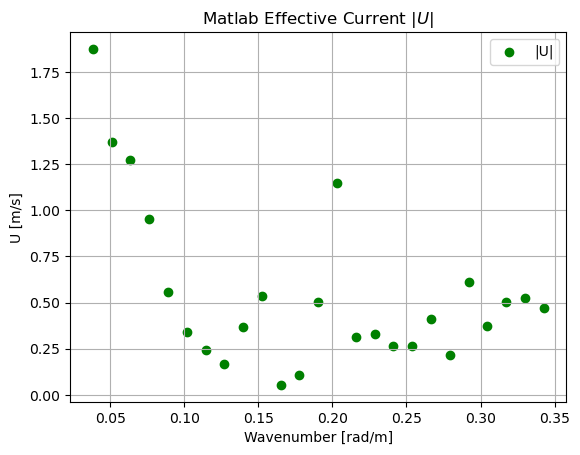

In [115]:
plt.scatter(k_matlab, np.sqrt(Ux_matlab**2+Uy_matlab**2), label='|U|', color = 'green')

plt.grid(True)
plt.legend()
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title('Matlab Effective Current $|U|$')

In [317]:
Ux = Ux_matlab
Uy = Uy_matlab
wavenumbers = k_matlab

In [318]:
filtered_x = wavenumbers
filtered_y = np.sqrt(Ux**2+Uy**2)

In [319]:
filtered_x = np.insert(filtered_x, 0, 1e-8)
filtered_y = np.insert(filtered_y, 0, 1e-8)

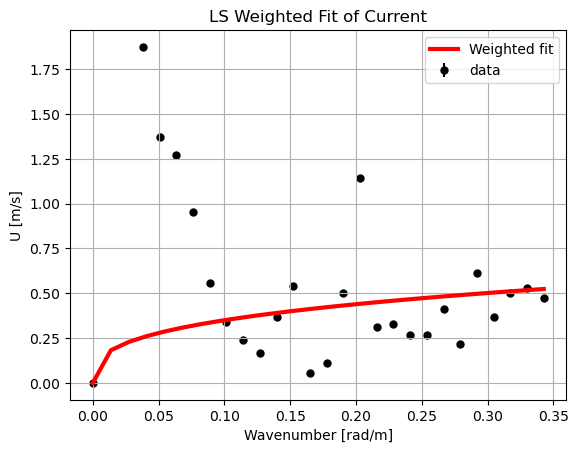

In [320]:
def fpow(x, a, b):
    return a * x**b 

def custom_weights(x):
    weights = np.ones_like(x)  # default weight for all points
    weights[(0 < x) & (x <= 0.2)] = 0.2  # medium error for 0 < x <= 0.2
    weights[x > 0.2] = 0.1  # low error for x > 0.15
    weights[np.isclose(x, 0, atol=1e-8)] = 0.001  # very low error for x = 0
    return weights

# initial guess
pars0 = (0.4, 0.4)

# perform fitting with custom weights
popt, pcov = curve_fit(fpow, filtered_x, filtered_y, absolute_sigma=True, p0=pars0, sigma=custom_weights(filtered_x), maxfev=5000)

# parameters
a_opt = popt[0]
b_opt = popt[1]

# plot data
plt.errorbar(filtered_x, filtered_y, yerr=0, fmt =".", color='black', label ='data', zorder=1, markersize=10)

# creating x interval to include in y fit
x_interval = np.linspace(0, max(filtered_x), len(filtered_x))
y_fit = fpow( x_interval , *popt)
plt.plot( x_interval, y_fit, color = "red", label = "Weighted fit", zorder=2 , linewidth=3)

plt.grid(True)
plt.ylabel("U [m/s]")
plt.xlabel("Wavenumber [rad/m]")
plt.title("LS Weighted Fit of Current")
plt.legend()
plt.show()

In [120]:
def rms(x):
    return np.sqrt(np.mean(x**2))

def pedm(k_vect, c_til, nMax_vals=None, deltaz_T_vals=None, deltaz_B_vals=None, waterDepth=16):

    # If user has not provided information about the waterDepth, set to infinity
    if waterDepth is None:
        waterDepth = np.inf

    # Handling for inadequate input data.
    if len(k_vect) == 0 or len(c_til) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan

    # Now we start with the PEDM. The steps follow those in the manuscript in section 2.1.2 Effect of limitations of measured Doppler shifts
    # Define the parameters.
    # Calculate effective depths of Doppler shift velocities based on assumption of a linear profile
    Z_eff = -(2 * k_vect) ** -1 * np.tanh(np.abs(waterDepth) * k_vect)

    # Set default values for PEDM parameter combinations if inputs left blank
    if nMax_vals is None:
        nm = min(12, round(len(k_vect) / 2))
        nMax_vals = np.arange(0, nm+1)
    
    if deltaz_T_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_T_vals = np.linspace(0.01, 0.2, 20) * depthRange

    if deltaz_B_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_B_vals = np.linspace(0.02, 0.8, 20) * depthRange

    z_c = max(4 * np.min(Z_eff), -np.abs(waterDepth))  # Cutoff depth chosen as 4 times the deepest mapped depth. (Set to water depth if depth is shallower)
    # z_c is NEGATIVE by convention here

    # We loop over all PEDM parameter combinations. First initialize eps_PEDM_out as well as the other outputs.
    eps_PEDM_out = np.inf
    eps_EDM_out = np.inf

    pPEDM_out = np.nan
    pEDM_out = np.nan

    verbose = []
    combo = 0

    for nMax in nMax_vals:
        for deltaz_B in deltaz_B_vals:
            for deltaz_T in deltaz_T_vals:
                # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
                p1 = np.polyfit(Z_eff, c_til, nMax)

                # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
                zB = np.linspace(0, deltaz_B, 100)
                zT = np.linspace(-deltaz_T, 0, 100)

                pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
                pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

                depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)
                depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]))

                zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
                cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

                # STEP 3: Perform a second polynomial fit on the expanded set of points
                pEDM = np.polyfit(zEx, cTilEx, nMax)

                # Determine if profile is monotonic with range of mapped depths.
                nv = np.arange(nMax, 0, -1)
                pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
                rts = np.roots(pczEx_p)  # Find roots
                rts = rts[np.isreal(rts)]  # Discard complex roots

                # If there roots of the derivative within ranges of mapped depths, don't go further.
                if np.any((rts > Z_eff[0]) & (rts < 0)):
                    continue

                # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article.
                pPEDM_i = pEDM / factorial(np.arange(nMax, -1, -1))

                # STEP 5: Create a new set of linearly extrapolated points down to z_c based on the average shear of the above polynomial function in a depth interval deltaz_B/2 at the deep end of the regime.
                zB2 = np.linspace(0, deltaz_B/2, 100)
                pBottom2 = np.polyfit(Z_eff[0] + zB, np.polyval(pPEDM_i, Z_eff[0] + zB), 1)

                depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B/2)

                zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))
                Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff), np.polyval(pPEDM_i, depthsExTop)))

                # STEP 6: Perform a final polynomial fit on the expanded set of points.
                pPEDM = np.polyfit(zEx2, Uvals, nMax)

                # Calculate Doppler shifts assuming U_EDM or U_PEDM as the current profile, using the forward problem.
                c_tilEDM = 0
                c_tilPEDM = 0

                if nMax < 2:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + factorial(n) * pEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                        c_tilPEDM = c_tilPEDM + factorial(n) * pPEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                else:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)
                        c_tilPEDM = c_tilPEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pPEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)

                # Calculate RMS differences (equation (9) in manuscript)
                eps_EDM = rms(c_til - c_tilEDM)  # RMS difference for U_EDM
                eps_PEDM = rms(c_til - c_tilPEDM)  # RMS difference for U_PEDM.

                # Parameters nMax, deltaz_T, and deltaz_B are chosen to minimize eps_PEDM in practice.
                if eps_PEDM < eps_PEDM_out:
                    eps_PEDM_out = eps_PEDM
                    pPEDM_out = pPEDM
                    nMax_out = nMax
                    deltaz_B_out = deltaz_B
                    deltaz_T_out = deltaz_T

                if eps_EDM < eps_EDM_out:
                    eps_EDM_out = eps_EDM
                    pEDM_out = pEDM

                combo = combo + 1

                verbose.append({
                    #'pPEDM': pPEDM.tolist(),
                    #'pEDM': pEDM.tolist(),
                    'pPEDM': pPEDM,
                    'pEDM': pEDM,
                    'eps_PEDM': eps_PEDM,
                    'eps_EDM': eps_EDM,
                    'nMax': nMax,
                    'deltaz_B': deltaz_B,
                    'deltaz_T': deltaz_T
                })

                
                #return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose
    return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose

In [121]:
pPEDM1, pEDM1, eps_PEDM1, eps_EDM1, verbose1 = pedm(x_interval[1:], y_fit[1:])

In [122]:
z = np.linspace(-20, 0, 100)
U1_fun = lambda z: np.polyval(pPEDM1, z)

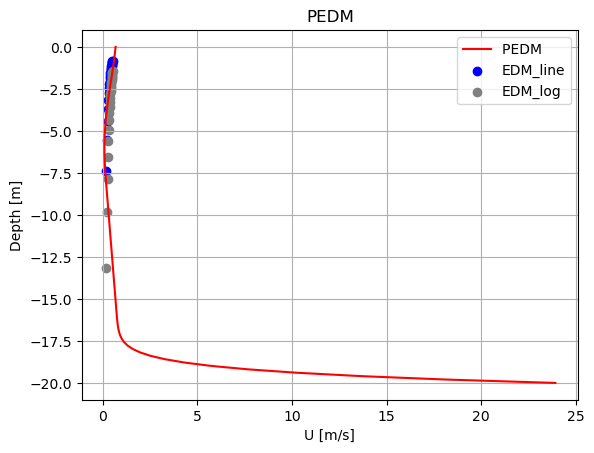

In [123]:
plt.plot(U1_fun(z), z, label="PEDM ", color = 'red')

plt.scatter( y_fit[1:],-1/(3.56*wavenumbers), label='EDM_line', color = 'blue')
plt.scatter( y_fit[1:],-1/(2*wavenumbers), label='EDM_log', color = 'grey')

plt.grid(True)
plt.title("PEDM")
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

In [124]:
hf = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\ADCP_19_01_22_04.mat', 'r')
east_vel = np.array(hf['East_vel'])
north_vel = np.array(hf['North_vel'])
vertical_vel = np.array(hf['Vertical_vel'])
z = np.array(hf['z_vec'])
t = hf['time_vec']
hf.close()

time_start = 0*60 # sec
time_stop = 15*60 # sec
time_step = 1 #sec
start_i = int(time_start/time_step)
stop_i = int(time_stop/time_step)

east_vel_mean = np.mean(east_vel[start_i:stop_i], axis=0)
north_vel_mean = np.mean(north_vel[start_i:stop_i], axis=0)
vertical_vel_mean = np.mean(vertical_vel[start_i:stop_i], axis=0)

(-20.0, 0.0)

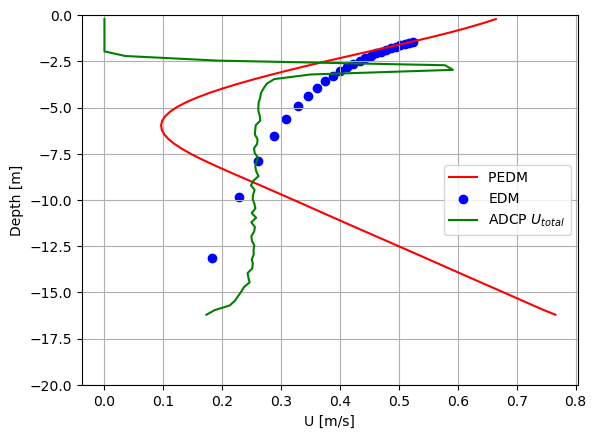

In [125]:
plt.plot(U1_fun(z), z, label="PEDM ", color = 'red')
plt.scatter( y_fit[1:],-1/(2*wavenumbers), label='EDM', color = 'blue')

U = np.sqrt(north_vel_mean**2+east_vel_mean**2)
plt.plot(U, z, label='ADCP $U_{total}$', color = 'green')

plt.grid(True)
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

plt.ylim(-20,0)

# 2) Start Trying Things

In [126]:
def rms(x):
    return np.sqrt(np.mean(x**2))

def pedm(k_vect, c_til, nMax_vals=None, deltaz_T_vals=None, deltaz_B_vals=None, waterDepth=None):
    # Calculate effective depths of Doppler shift velocities based on assumption of a linear profile
    Z_eff = -(2 * k_vect) ** -1 * np.tanh(np.abs(waterDepth) * k_vect)

    # Set default values for PEDM parameter combinations if inputs left blank
    if nMax_vals is None:
        nm = min(12, round(len(k_vect) / 2))
        nMax_vals = np.arange(0, nm+1)
    
    if deltaz_T_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_T_vals = np.linspace(0.01, 0.2, 20) * depthRange

    if deltaz_B_vals is None:
        depthRange = np.abs(Z_eff[0] - Z_eff[-1])
        deltaz_B_vals = np.linspace(0.02, 0.8, 20) * depthRange

    z_c = max(4 * np.min(Z_eff), -np.abs(waterDepth))  # Cutoff depth chosen as 4 times the deepest mapped depth. (Set to water depth if depth is shallower)
    # z_c is NEGATIVE by convention here

    # We loop over all PEDM parameter combinations. First initialize eps_PEDM_out as well as the other outputs.
    eps_PEDM_out = np.inf
    eps_EDM_out = np.inf

    pPEDM_out = np.nan
    pEDM_out = np.nan

    verbose = []
    combo = 0

    for nMax in nMax_vals:
        for deltaz_B in deltaz_B_vals:
            for deltaz_T in deltaz_T_vals:
                # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
                p1 = np.polyfit(Z_eff, c_til, nMax)

                # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
                zB = np.linspace(0, deltaz_B, 100)
                zT = np.linspace(-deltaz_T, 0, 100)

                pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
                pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

                depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)
                depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]))

                zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
                cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

                # STEP 3: Perform a second polynomial fit on the expanded set of points
                pEDM = np.polyfit(zEx, cTilEx, nMax)

                # Determine if profile is monotonic with range of mapped depths.
                nv = np.arange(nMax, 0, -1)
                pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
                rts = np.roots(pczEx_p)  # Find roots
                rts = rts[np.isreal(rts)]  # Discard complex roots

                # If there roots of the derivative within ranges of mapped depths, don't go further.
                if np.any((rts > Z_eff[0]) & (rts < 0)):
                    continue

                # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article.
                pPEDM_i = pEDM / factorial(np.arange(nMax, -1, -1))

                # STEP 5: Create a new set of linearly extrapolated points down to z_c based on the average shear of the above polynomial function in a depth interval deltaz_B/2 at the deep end of the regime.
                zB2 = np.linspace(0, deltaz_B/2, 100)
                pBottom2 = np.polyfit(Z_eff[0] + zB, np.polyval(pPEDM_i, Z_eff[0] + zB), 1)

                depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B/2)

                zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))
                Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff), np.polyval(pPEDM_i, depthsExTop)))

                # STEP 6: Perform a final polynomial fit on the expanded set of points.
                pPEDM = np.polyfit(zEx2, Uvals, nMax)

                # Calculate Doppler shifts assuming U_EDM or U_PEDM as the current profile, using the forward problem.
                c_tilEDM = 0
                c_tilPEDM = 0

                if nMax < 2:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + factorial(n) * pEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                        c_tilPEDM = c_tilPEDM + factorial(n) * pPEDM[-n-1] * (-1 / (2 * k_vect)) ** n
                else:
                    for n in range(nMax + 1):
                        c_tilEDM = c_tilEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)
                        c_tilPEDM = c_tilPEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pPEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)

                # Calculate RMS differences (equation (9) in manuscript)
                eps_EDM = rms(c_til - c_tilEDM)  # RMS difference for U_EDM
                eps_PEDM = rms(c_til - c_tilPEDM)  # RMS difference for U_PEDM.

                # Parameters nMax, deltaz_T, and deltaz_B are chosen to minimize eps_PEDM in practice.
                if eps_PEDM < eps_PEDM_out:
                    eps_PEDM_out = eps_PEDM
                    pPEDM_out = pPEDM
                    nMax_out = nMax
                    deltaz_B_out = deltaz_B
                    deltaz_T_out = deltaz_T

                if eps_EDM < eps_EDM_out:
                    eps_EDM_out = eps_EDM
                    pEDM_out = pEDM

                combo = combo + 1

                verbose.append({
                    #'pPEDM': pPEDM.tolist(),
                    #'pEDM': pEDM.tolist(),
                    'pPEDM': pPEDM,
                    'pEDM': pEDM,
                    'eps_PEDM': eps_PEDM,
                    'eps_EDM': eps_EDM,
                    'nMax': nMax,
                    'deltaz_B': deltaz_B,
                    'deltaz_T': deltaz_T
                })

                
                #return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose
    return pPEDM_out, pEDM_out, eps_PEDM_out, eps_EDM_out, verbose

In [325]:
k_vect = x_interval[1:]
c_til = y_fit[1:]

In [326]:
waterDepth = 16

In [327]:
Z_eff = -(2 * k_vect) ** -1 * np.tanh(np.abs(waterDepth) * k_vect)

In [328]:
np.tanh(np.abs(waterDepth) * k_vect)

array([0.21588919, 0.41255018, 0.5770448 , 0.70509486, 0.79931104,
       0.86579618, 0.9113411 , 0.94191061, 0.96214852, 0.97542492,
       0.9840824 , 0.98970586, 0.99334929, 0.99570597, 0.99722873,
       0.99821196, 0.99884655, 0.999256  , 0.99952014, 0.99969052,
       0.99980041, 0.99987128, 0.99991699, 0.99994647, 0.99996548])

In [329]:
nm = min(12, round(len(k_vect) / 2))
nMax_vals = np.arange(0, nm+1)
    
depthRange = np.abs(Z_eff[0] - Z_eff[-1])
deltaz_T_vals = np.linspace(0.01, 0.2, 20) * depthRange

depthRange = np.abs(Z_eff[0] - Z_eff[-1])
deltaz_B_vals = np.linspace(0.02, 0.8, 20) * depthRange

In [330]:
nMax_vals

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [331]:
deltaz_T_vals

array([0.06415258, 0.12830516, 0.19245774, 0.25661032, 0.3207629 ,
       0.38491548, 0.44906806, 0.51322064, 0.57737322, 0.6415258 ,
       0.70567838, 0.76983096, 0.83398354, 0.89813612, 0.9622887 ,
       1.02644128, 1.09059386, 1.15474644, 1.21889902, 1.28305161])

In [332]:
deltaz_B_vals

array([0.12830516, 0.39166838, 0.65503161, 0.91839483, 1.18175806,
       1.44512128, 1.70848451, 1.97184773, 2.23521095, 2.49857418,
       2.7619374 , 3.02530063, 3.28866385, 3.55202708, 3.8153903 ,
       4.07875352, 4.34211675, 4.60547997, 4.8688432 , 5.13220642])

In [333]:
z_c = max(4 * np.min(Z_eff), -np.abs(waterDepth))  # Cutoff depth chosen as 4 times the deepest mapped depth. (Set to water depth if depth is shallower)
    # z_c is NEGATIVE by convention here

In [334]:
z_c

-16

In [335]:
   # We loop over all PEDM parameter combinations. First initialize eps_PEDM_out as well as the other outputs.
eps_PEDM_out = np.inf
eps_EDM_out = np.inf

pPEDM_out = np.nan
pEDM_out = np.nan

verbose = []
combo = 0

In [336]:
Z_eff.shape, c_til.shape

((25,), (25,))

# Step 1

In [337]:
for nMax in nMax_vals:
    for deltaz_B in deltaz_B_vals:
        for deltaz_T in deltaz_T_vals:
            
            # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
            p1 = np.polyfit(Z_eff, c_til, nMax)

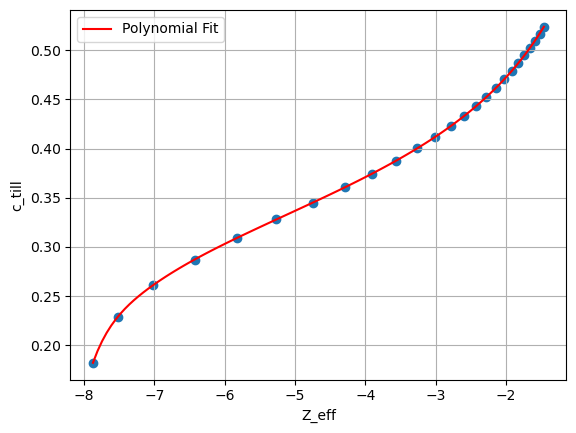

In [338]:
plt.scatter(Z_eff, c_til)

# Generate points for the polynomial curve
x_fit = np.linspace(Z_eff.min(), Z_eff.max(), 100)
J_fit = np.polyval(p1, x_fit)
plt.plot(x_fit, J_fit, color='red', label='Polynomial Fit')


plt.grid(True)
plt.xlabel("Z_eff")
plt.ylabel("c_till")
plt.legend()

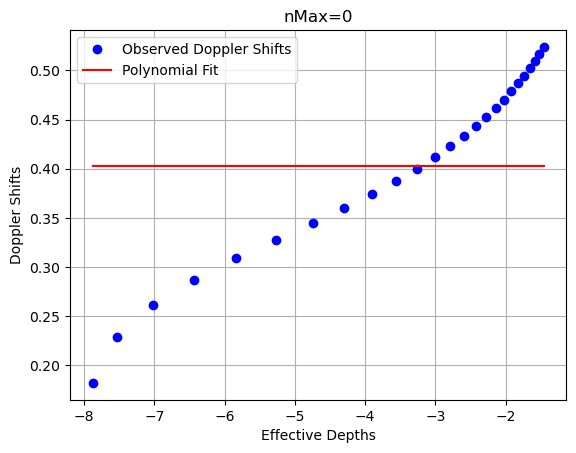

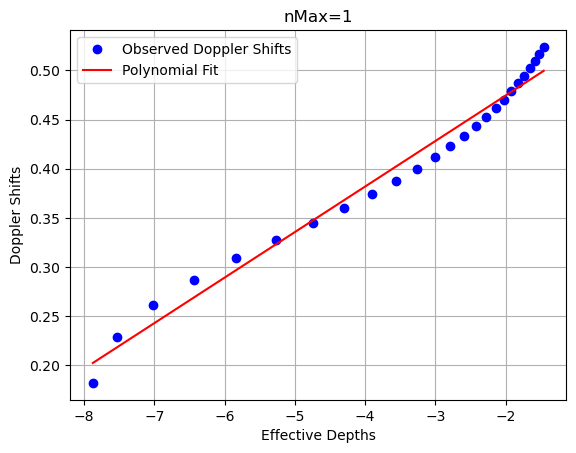

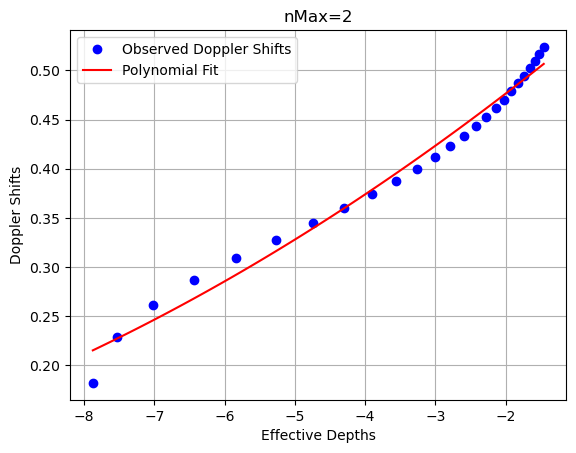

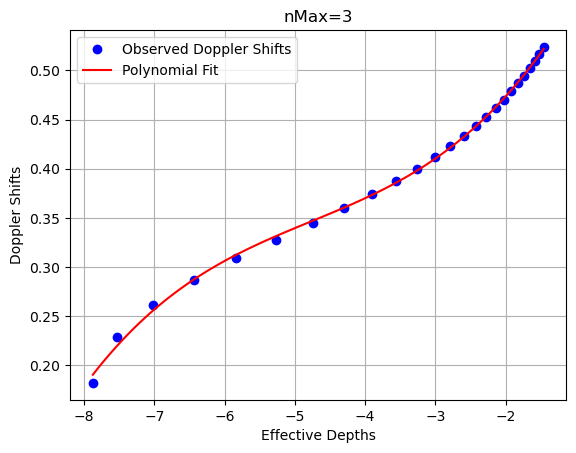

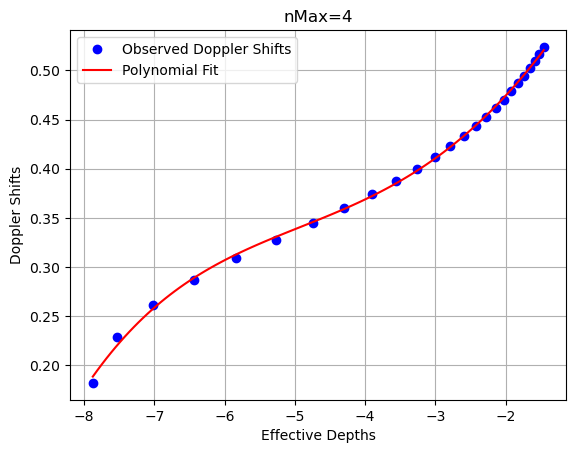

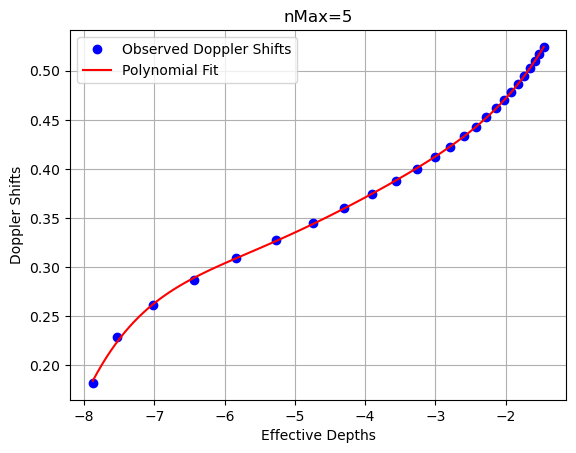

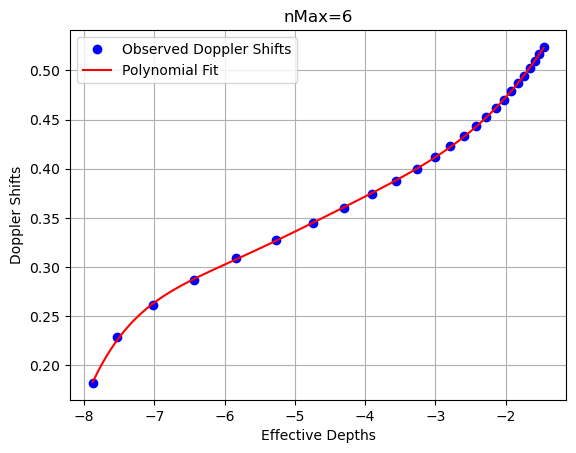

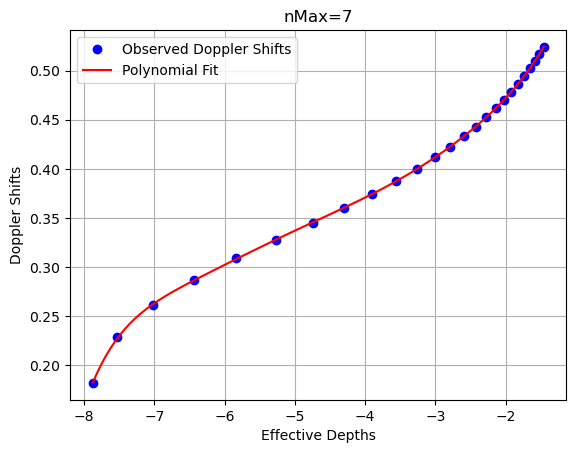

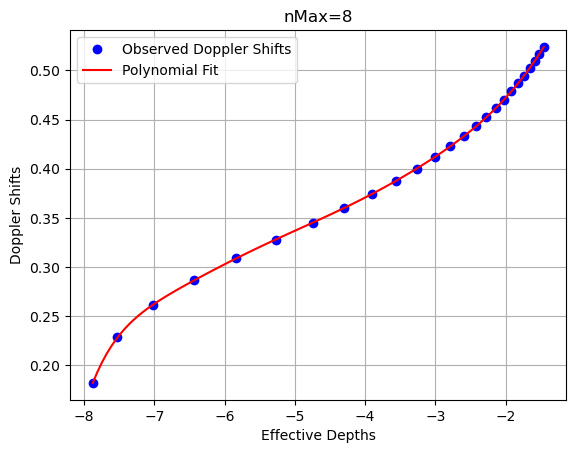

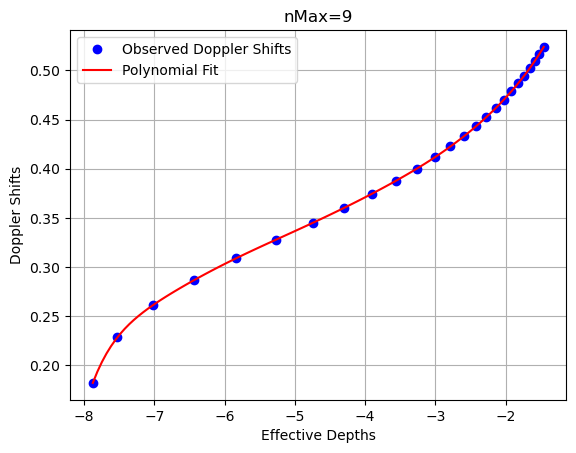

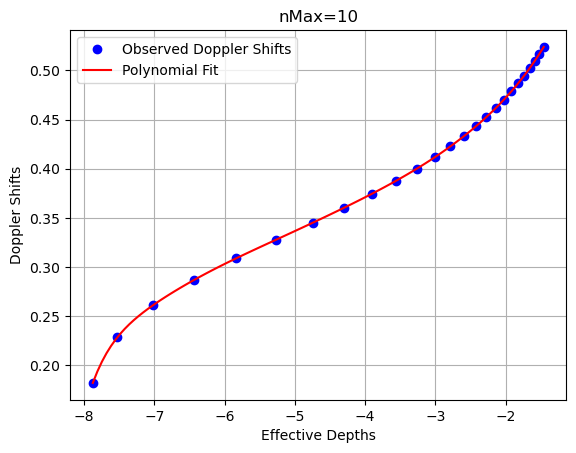

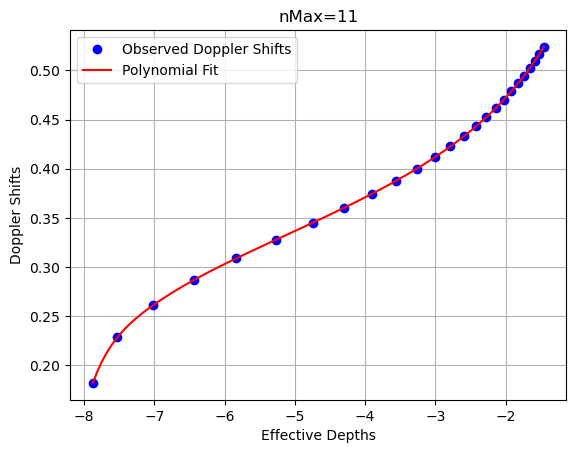

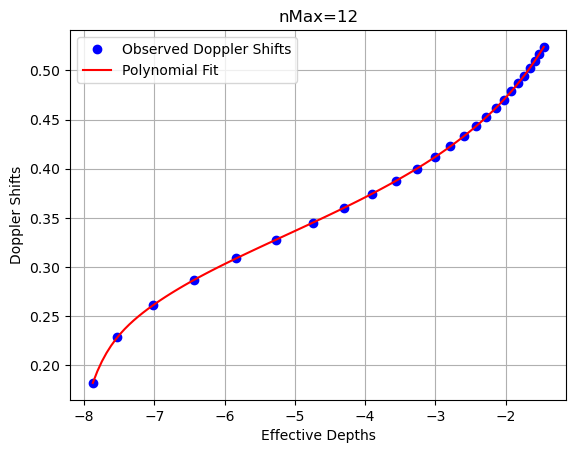

In [339]:
import matplotlib.pyplot as plt

for nMax in nMax_vals:
    # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
    p1 = np.polyfit(Z_eff, c_til, nMax)

    # Generate points for the polynomial curve
    x_fit = np.linspace(Z_eff.min(), Z_eff.max(), 100)
    J_fit = np.polyval(p1, x_fit)

    # Plot the polynomial fit for this combination of parameters
    plt.figure()  # Create a new figure for each combination
    plt.plot(Z_eff, c_til, 'bo', label='Observed Doppler Shifts')  # Plot observed data points
    plt.plot(x_fit, J_fit, color='red', label='Polynomial Fit')  # Plot polynomial fit
    plt.xlabel('Effective Depths')
    plt.ylabel('Doppler Shifts')
    plt.grid(True)
    plt.title(f'nMax={nMax}')
    plt.legend()
    plt.show()  # Show the plot for this combination


# Step 2 and 3

In [340]:
for nMax in nMax_vals:
    for deltaz_B in deltaz_B_vals:
        for deltaz_T in deltaz_T_vals:
            # STEP 1: Fit the mapped Doppler shifts to a polynomial of order nMax.
            p1 = np.polyfit(Z_eff, c_til, nMax)

            # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
            zB = np.linspace(0, deltaz_B, 100)
            zT = np.linspace(-deltaz_T, 0, 100)

            pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
            pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

            depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B, deltaz_B)
            depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T, 0, deltaz_T), [0]))

            zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
            cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

            # STEP 3: Perform a second polynomial fit on the expanded set of points
            pEDM = np.polyfit(zEx, cTilEx, nMax)

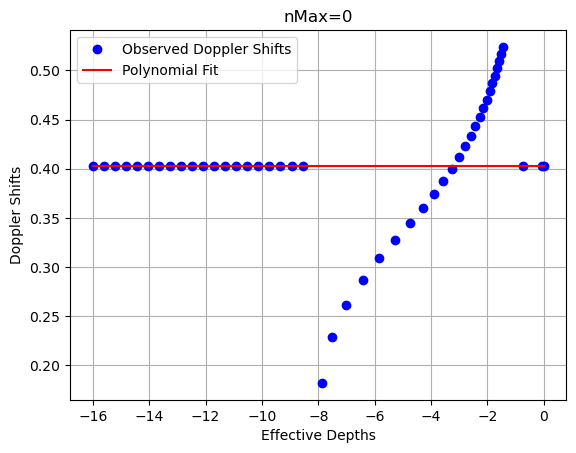

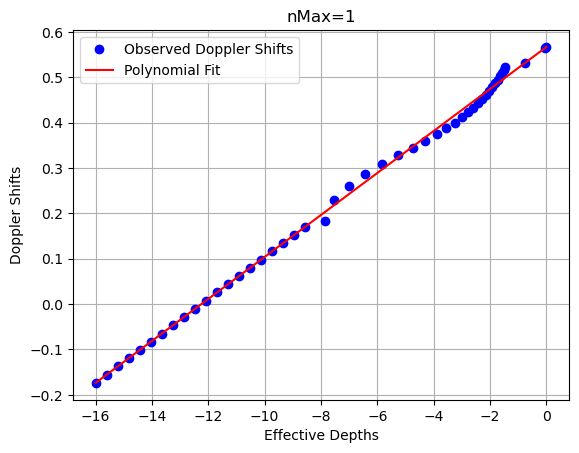

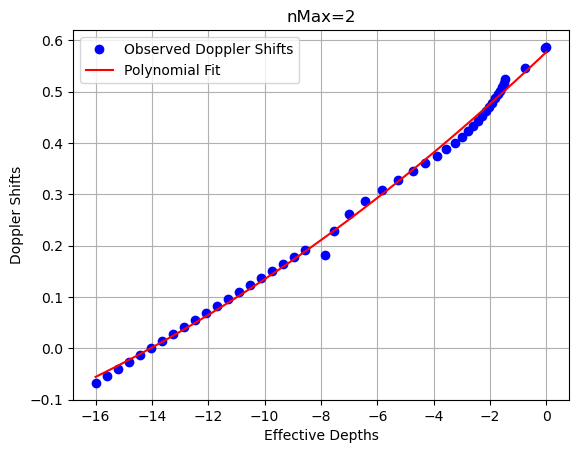

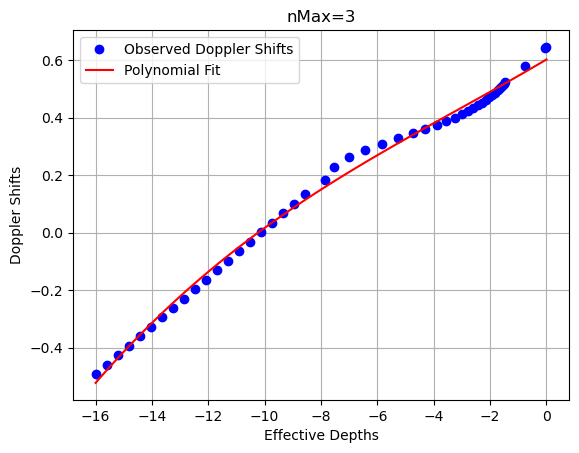

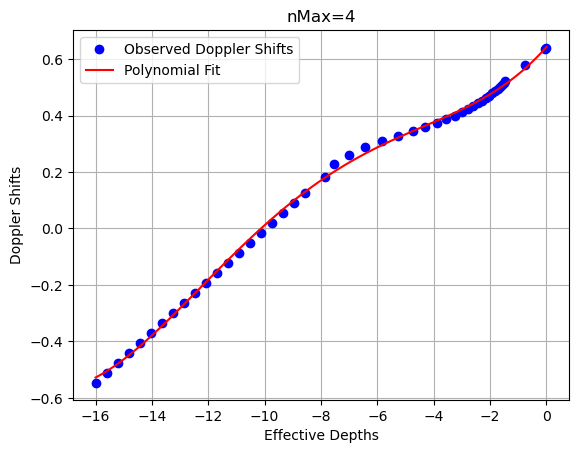

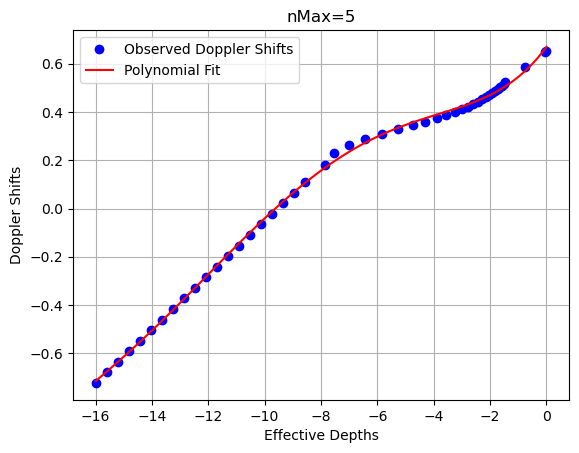

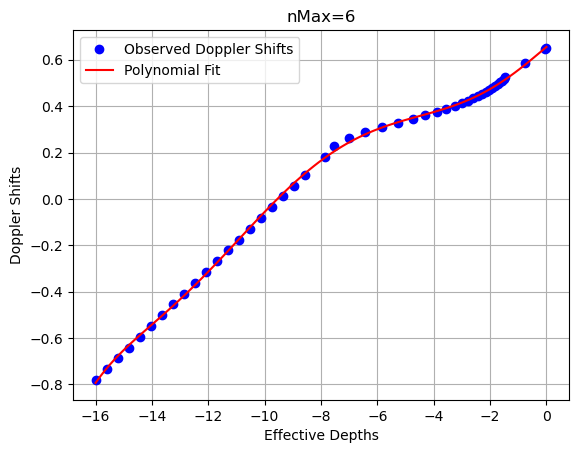

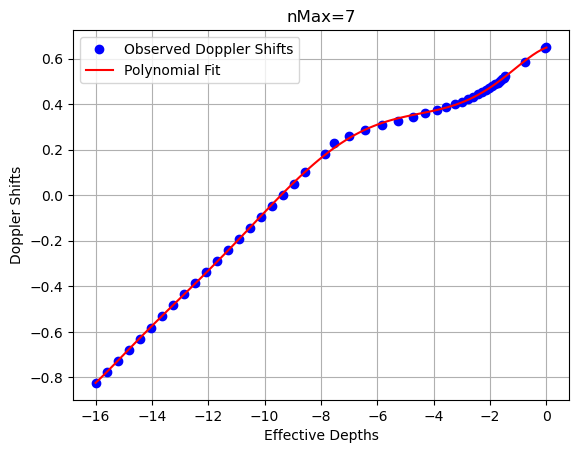

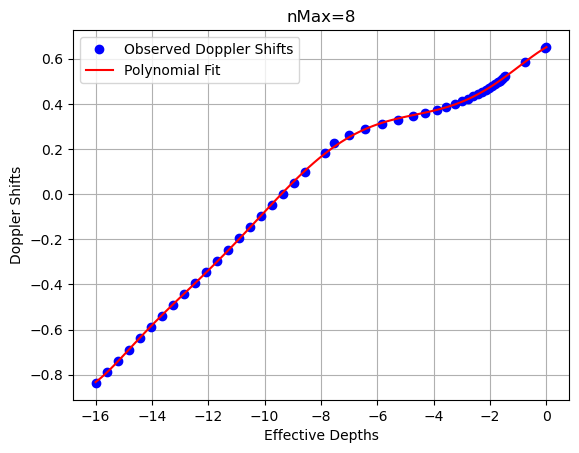

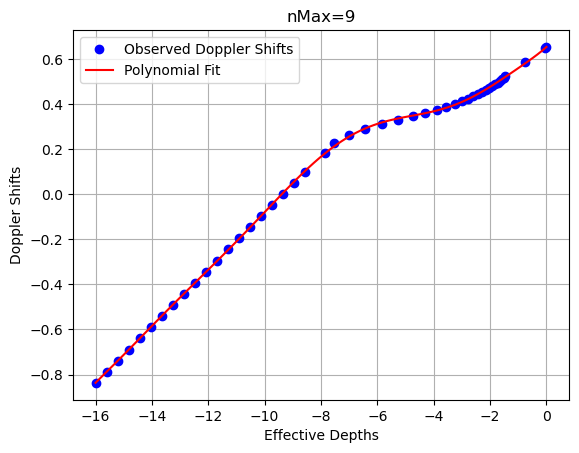

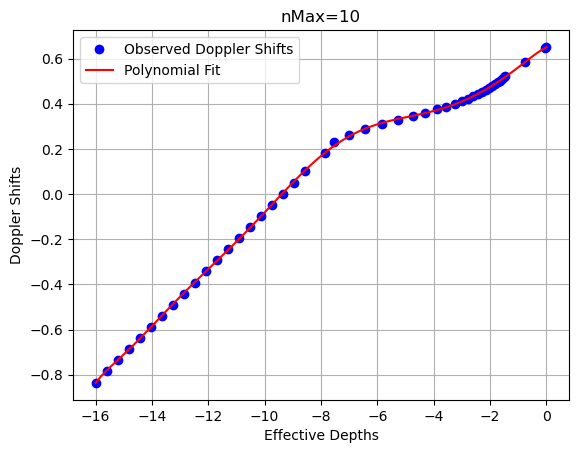

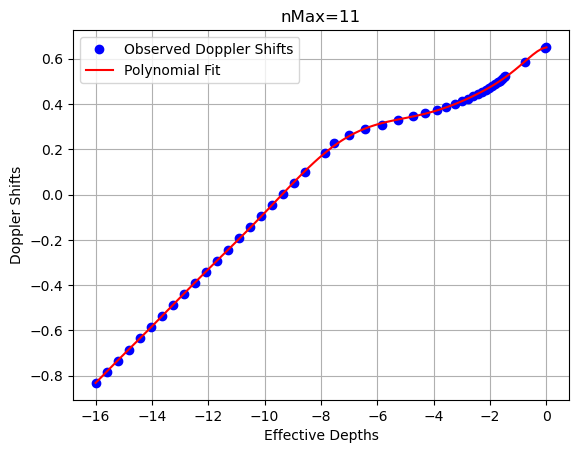

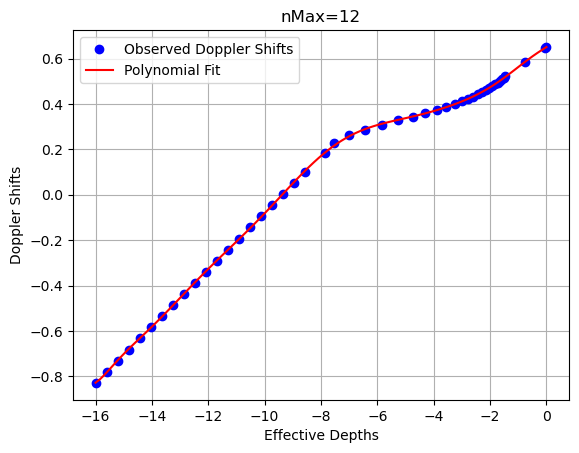

In [341]:
for nMax in nMax_vals:
    i = 1
    j = 10
    # indices of deltaz_B_vals and deltaz_T_vals
    
    p1 = np.polyfit(Z_eff, c_til, nMax)

    # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
    zB = np.linspace(0, deltaz_B_vals[i], 100)
    zT = np.linspace(-deltaz_T_vals[j], 0, 100)

    pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
    pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

    depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B_vals[i], deltaz_B_vals[i])
    depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T_vals[j], 0, deltaz_T_vals[j]), [0]))

    zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
    cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

    # STEP 3: Perform a second polynomial fit on the expanded set of points
    pEDM = np.polyfit(zEx, cTilEx, nMax)

    # Generate points for the polynomial curve
    x_fit = np.linspace(zEx.min(), zEx.max(), 100)
    J_fit = np.polyval(pEDM, x_fit)

    # Plot the polynomial fit for this combination of parameters
    plt.figure()  # Create a new figure for each combination
    plt.plot(zEx, cTilEx, 'bo', label='Observed Doppler Shifts')  # Plot observed data points
    plt.plot(x_fit, J_fit, color='red', label='Polynomial Fit')  # Plot polynomial fit
    plt.xlabel('Effective Depths')
    plt.ylabel('Doppler Shifts')
    plt.grid(True)
    plt.title(f'nMax={nMax}')
    plt.legend()
    plt.show()  # Show the plot for this combination

# Monotomic check 

## Old way

In [315]:
for nMax in nMax_vals:
    i = 1
    j = 10
    # indices of deltaz_B_vals and deltaz_T_vals
    
    p1 = np.polyfit(Z_eff, c_til, nMax)

    # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
    zB = np.linspace(0, deltaz_B_vals[i], 100)
    zT = np.linspace(-deltaz_T_vals[j], 0, 100)

    pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
    pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

    depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B_vals[i], deltaz_B_vals[i])
    depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T_vals[j], 0, deltaz_T_vals[j]), [0]))

    zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
    cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

    # STEP 3: Perform a second polynomial fit on the expanded set of points
    pEDM = np.polyfit(zEx, cTilEx, nMax)
    '''
    # Generate points for the polynomial curve
    x_fit = np.linspace(zEx.min(), zEx.max(), 100)
    J_fit = np.polyval(pEDM, x_fit)

    # Plot the polynomial fit for this combination of parameters
    plt.figure()  # Create a new figure for each combination
    plt.plot(zEx, cTilEx, 'bo', label='Observed Doppler Shifts')  # Plot observed data points
    plt.plot(x_fit, J_fit, color='red', label='Polynomial Fit')  # Plot polynomial fit
    plt.xlabel('Effective Depths')
    plt.ylabel('Doppler Shifts')
    plt.grid(True)
    plt.title(f'nMax={nMax}')
    plt.legend()
    plt.show()  # Show the plot for this combination
    '''

    # Determine if profile is monotonic with range of mapped depths.
    nv = np.arange(nMax, 0, -1)
    pczEx_p = nv * pEDM[:-1]  # Derivative polynomial coefficients
    rts = np.roots(pczEx_p)  # Find roots
    rts = rts[np.isreal(rts)]  # Discard complex roots

    # If there roots of the derivative within ranges of mapped depths, don't go further.
    if np.any((rts > Z_eff[0]) & (rts < 0)):
        print(f"nMax = {nMax}: Loops continues")

    else:
        print(f"nMax = {nMax}: STOPS - not MONOTONIC")

nMax = 0: STOPS - not MONOTONIC
nMax = 1: STOPS - not MONOTONIC
nMax = 2: Loops continues
nMax = 3: STOPS - not MONOTONIC
nMax = 4: Loops continues
nMax = 5: Loops continues
nMax = 6: Loops continues
nMax = 7: Loops continues
nMax = 8: Loops continues
nMax = 9: Loops continues
nMax = 10: Loops continues
nMax = 11: Loops continues
nMax = 12: Loops continues


## New Way

In [343]:
for nMax in nMax_vals:
    i = 1
    j = 10
    # indices of deltaz_B_vals and deltaz_T_vals
    
    p1 = np.polyfit(Z_eff, c_til, nMax)

    # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
    zB = np.linspace(0, deltaz_B_vals[i], 100)
    zT = np.linspace(-deltaz_T_vals[j], 0, 100)

    pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
    pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

    depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B_vals[i], deltaz_B_vals[i])
    depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T_vals[j], 0, deltaz_T_vals[j]), [0]))

    zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
    cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

    # STEP 3: Perform a second polynomial fit on the expanded set of points
    pEDM = np.polyfit(zEx, cTilEx, nMax)

    # Generate points for the polynomial curve
    x_fit = np.linspace(zEx.min(), zEx.max(), 100)
    F_fit = np.polyval(pEDM, x_fit)

    is_monotonic = np.all(np.diff(F_fit) > 0) or np.all(np.diff(F_fit) < 0)

    # If there roots of the derivative within ranges of mapped depths, don't go further.
    if is_monotonic:
        print(f"nMax = {nMax}: Loops continues")

    else:
        print(f"nMax = {nMax}: STOPS - not MONOTONIC")

nMax = 0: STOPS - not MONOTONIC
nMax = 1: Loops continues
nMax = 2: Loops continues
nMax = 3: Loops continues
nMax = 4: Loops continues
nMax = 5: Loops continues
nMax = 6: Loops continues
nMax = 7: Loops continues
nMax = 8: Loops continues
nMax = 9: Loops continues
nMax = 10: Loops continues
nMax = 11: Loops continues
nMax = 12: Loops continues


# Step 4, 5 and 6

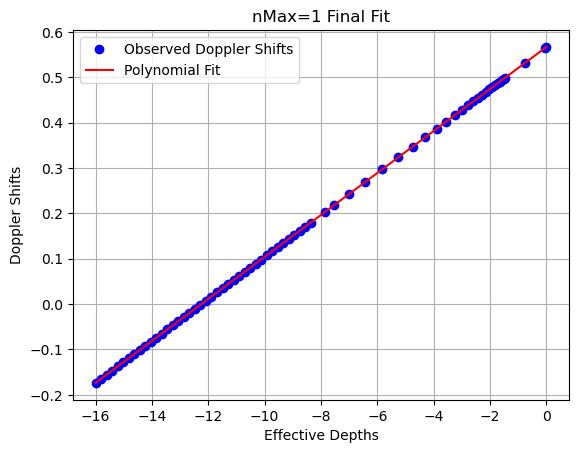

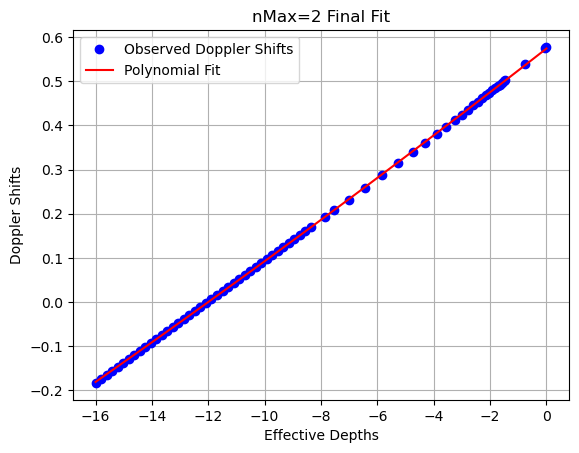

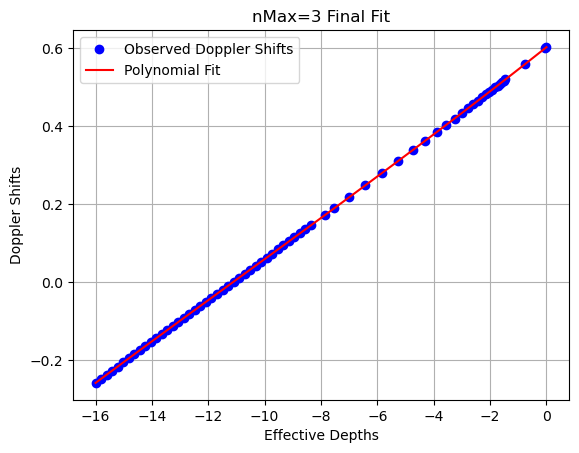

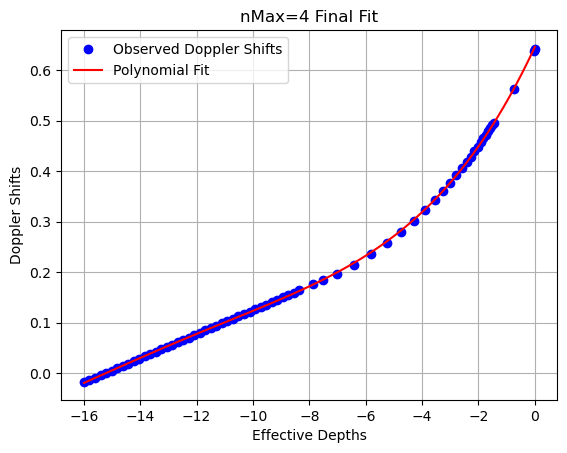

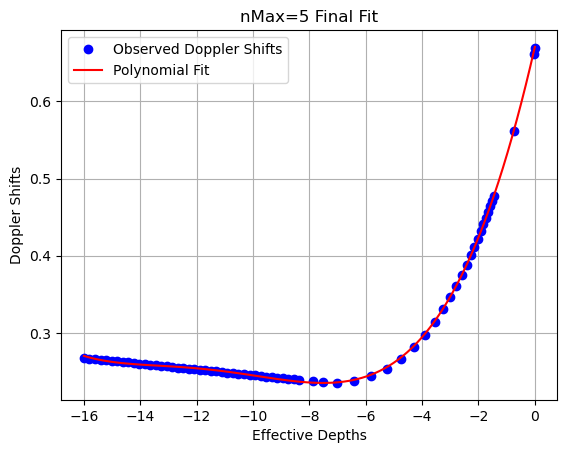

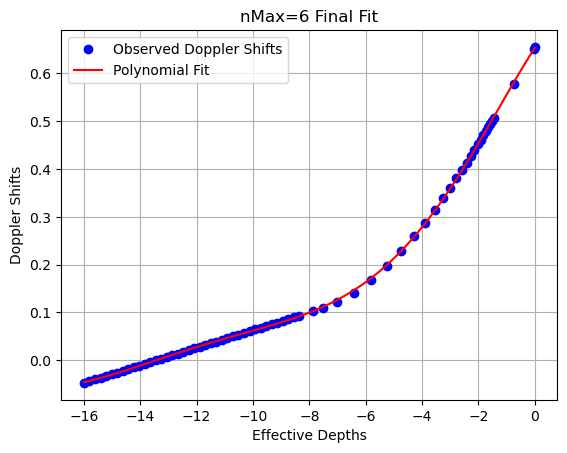

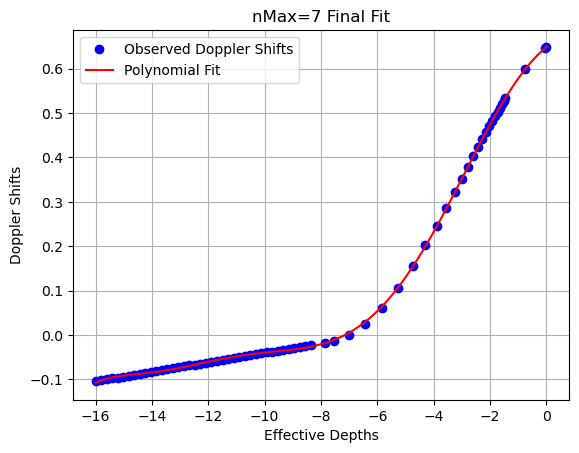

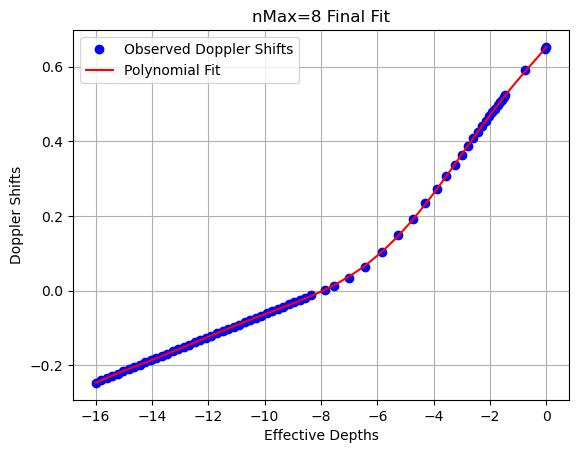

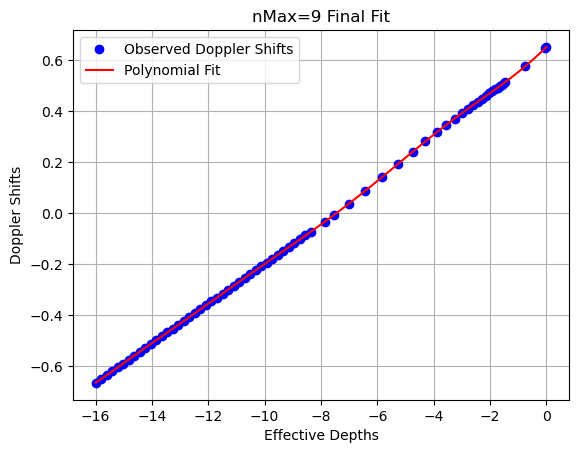

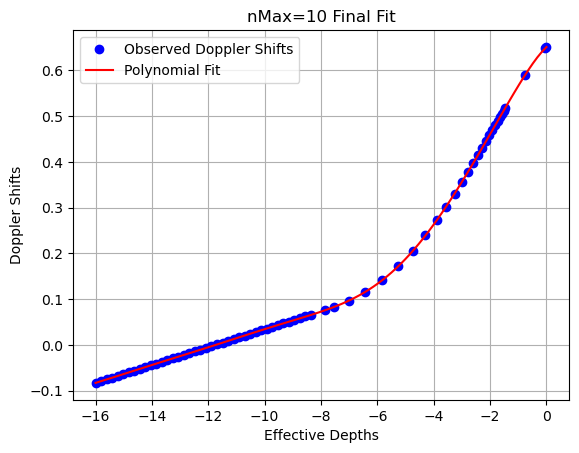

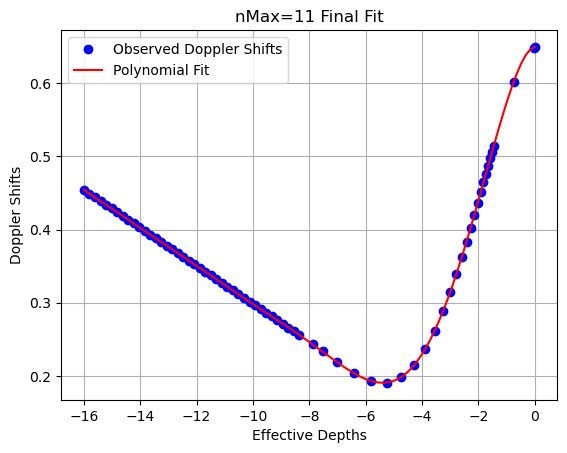

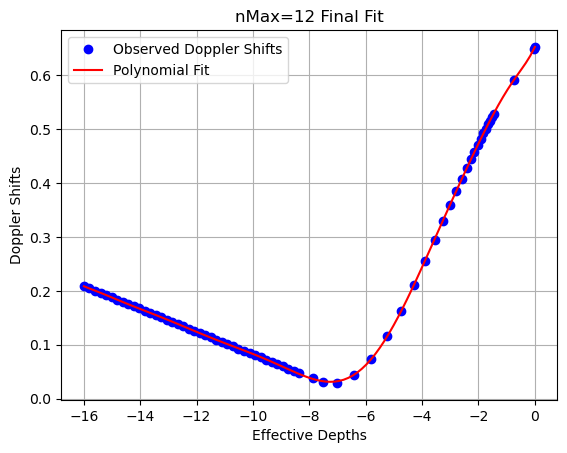

In [351]:
for nMax in nMax_vals:
    i = 1
    j = 10
    # indices of deltaz_B_vals and deltaz_T_vals
    
    p1 = np.polyfit(Z_eff, c_til, nMax)

    # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
    zB = np.linspace(0, deltaz_B_vals[i], 100)
    zT = np.linspace(-deltaz_T_vals[j], 0, 100)

    pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
    pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

    depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B_vals[i], deltaz_B_vals[i])
    depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T_vals[j], 0, deltaz_T_vals[j]), [0]))

    zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
    cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

    # STEP 3: Perform a second polynomial fit on the expanded set of points
    pEDM = np.polyfit(zEx, cTilEx, nMax)

    # Generate points for the polynomial curve
    x_fit = np.linspace(zEx.min(), zEx.max(), 100)
    F_fit = np.polyval(pEDM, x_fit)

    is_monotonic = np.all(np.diff(F_fit) > 0) or np.all(np.diff(F_fit) < 0)

    # If there roots of the derivative within ranges of mapped depths, don't go further.
    if not is_monotonic:
        continue

    # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article.
    pPEDM_i = pEDM / factorial(np.arange(nMax, -1, -1))

    # STEP 5: Create a new set of linearly extrapolated points down to z_c based on the average shear of the above polynomial function in a depth interval deltaz_B/2 at the deep end of the regime.
    zB2 = np.linspace(0, deltaz_B_vals[i]/2, 100)
    pBottom2 = np.polyfit(Z_eff[0] + zB, np.polyval(pPEDM_i, Z_eff[0] + zB), 1)

    depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B_vals[i], deltaz_B_vals[i]/2)

    zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))
    Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff), np.polyval(pPEDM_i, depthsExTop)))

    # STEP 6: Perform a final polynomial fit on the expanded set of points.
    pPEDM = np.polyfit(zEx2, Uvals, nMax)

    # Generate points for the polynomial curve
    x_last_fit = np.linspace(zEx.min(), zEx.max(), 100)
    F_last_fit = np.polyval(pPEDM, x_fit)

    # Plot the polynomial fit for this combination of parameters
    plt.figure()  # Create a new figure for each combination
    plt.plot(zEx2, Uvals, 'bo', label='Observed Doppler Shifts')  # Plot observed data points
    plt.plot(x_last_fit, F_last_fit, color='red', label='Polynomial Fit')  # Plot polynomial fit
    plt.xlabel('Effective Depths')
    plt.ylabel('Doppler Shifts')
    plt.grid(True)
    plt.title(f'nMax={nMax} Final Fit')
    plt.legend()
    plt.show()  # Show the plot for this combination


    

# Find Doppler shifts and Minimise RMS

In [362]:
eps_EDM_output = []
eps_PEDM_output = []

array_PEDM = []
array_EDM = []

for nMax in nMax_vals:
    i = 1
    j = 10
    # indices of deltaz_B_vals and deltaz_T_vals
    
    p1 = np.polyfit(Z_eff, c_til, nMax)

    # STEP 2: Create additional velocity-depth pairs by linearly extrapolating up to the surface and down to cutoff depth z_c
    zB = np.linspace(0, deltaz_B_vals[i], 100)
    zT = np.linspace(-deltaz_T_vals[j], 0, 100)

    pTop = np.polyfit(Z_eff[-1] + zT, np.polyval(p1, Z_eff[-1] + zT), 1)
    pBottom = np.polyfit(Z_eff[0] + zB, np.polyval(p1, Z_eff[0] + zB), 1)

    depthsExBtm = np.arange(z_c, Z_eff[0] - deltaz_B_vals[i], deltaz_B_vals[i])
    depthsExTop = np.concatenate((np.arange(Z_eff[-1] + deltaz_T_vals[j], 0, deltaz_T_vals[j]), [0]))

    zEx = np.concatenate((depthsExBtm, Z_eff, depthsExTop))
    cTilEx = np.concatenate((np.polyval(pBottom, depthsExBtm), c_til, np.polyval(pTop, depthsExTop)))

    # STEP 3: Perform a second polynomial fit on the expanded set of points
    pEDM = np.polyfit(zEx, cTilEx, nMax)

    # Generate points for the polynomial curve
    x_fit = np.linspace(zEx.min(), zEx.max(), 100)
    F_fit = np.polyval(pEDM, x_fit)

    is_monotonic = np.all(np.diff(F_fit) > 0) or np.all(np.diff(F_fit) < 0)

    # If there roots of the derivative within ranges of mapped depths, don't go further.
    if not is_monotonic:
        continue

    # STEP 4: Scale polynomial coefficients defining U_EDM by n! as in equation (8) in the article.
    pPEDM_i = pEDM / factorial(np.arange(nMax, -1, -1))

    # STEP 5: Create a new set of linearly extrapolated points down to z_c based on the average shear of the above polynomial function in a depth interval deltaz_B/2 at the deep end of the regime.
    zB2 = np.linspace(0, deltaz_B_vals[i]/2, 100)
    pBottom2 = np.polyfit(Z_eff[0] + zB, np.polyval(pPEDM_i, Z_eff[0] + zB), 1)

    depthsExBtm2 = np.arange(z_c, Z_eff[0] - deltaz_B_vals[i], deltaz_B_vals[i]/2)

    zEx2 = np.concatenate((depthsExBtm2, Z_eff, depthsExTop))
    Uvals = np.concatenate((np.polyval(pBottom2, depthsExBtm2), np.polyval(pPEDM_i, Z_eff), np.polyval(pPEDM_i, depthsExTop)))

    # STEP 6: Perform a final polynomial fit on the expanded set of points.
    pPEDM = np.polyfit(zEx2, Uvals, nMax)
    
    c_tilEDM = 0
    c_tilPEDM = 0

    if nMax < 2:
        for n in range(nMax + 1):
            c_tilEDM = c_tilEDM + factorial(n) * pEDM[-n-1] * (-1 / (2 * k_vect)) ** n
            c_tilPEDM = c_tilPEDM + factorial(n) * pPEDM[-n-1] * (-1 / (2 * k_vect)) ** n
    else:
        for n in range(nMax + 1):
            c_tilEDM = c_tilEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)
            c_tilPEDM = c_tilPEDM + (-1 / 2) ** (n) * k_vect ** (-n) * pPEDM[-n-1] * (gammainc(1 + n, -2 * k_vect * z_c)) * gamma(n + 1)

    # Calculate RMS differences (equation (9) in manuscript)
    eps_EDM = rms(c_til - c_tilEDM)  # RMS difference for U_EDM
    eps_PEDM = rms(c_til - c_tilPEDM)  # RMS difference for U_PEDM.

    eps_EDM_output.append(eps_EDM)
    eps_PEDM_output.append(eps_PEDM)

    array_PEDM.append(pPEDM)
    array_EDM.append(pEDM)
    
    #print(eps_EDM)
    #print(eps_PEDM)

    

In [368]:
arg_EDM = np.argmin(eps_EDM_output)
arg_PEDM = np.argmin(eps_PEDM_output)

In [369]:
arg_EDM, arg_PEDM

(1, 10)

In [371]:
array_EDM

[array([0.04630752, 0.56710793]),
 array([0.00078153, 0.05209813, 0.57755546]),
 array([1.18717643e-04, 1.12930837e-03, 5.79990391e-02, 6.02254291e-01]),
 array([5.79525490e-05, 1.92554894e-03, 1.84872648e-02, 1.13415203e-01,
        6.43116831e-01]),
 array([4.86457491e-06, 2.67458057e-04, 5.14524225e-03, 3.82127129e-02,
        1.57470548e-01, 6.69590785e-01]),
 array([-1.61474092e-06, -7.16588591e-05, -1.08778911e-03, -5.85638803e-03,
        -2.19165151e-03,  1.02170005e-01,  6.55193717e-01]),
 array([-2.83402321e-07, -1.74951370e-05, -4.21917746e-04, -4.92542104e-03,
        -2.74511370e-02, -6.00807965e-02,  4.42575782e-02,  6.48834118e-01]),
 array([ 2.36865927e-08,  1.23430723e-06,  2.20779915e-05,  1.16777006e-04,
        -8.44741939e-04, -1.05157443e-02, -2.49622879e-02,  7.27544872e-02,
         6.51466023e-01]),
 array([6.23590757e-09, 4.73716653e-07, 1.47984367e-05, 2.43308474e-04,
        2.23076120e-03, 1.11190172e-02, 2.80284637e-02, 3.85823568e-02,
        1.13636388e-

In [363]:
array_PEDM

[array([0.04630752, 0.56710793]),
 array([1.61765644e-04, 4.97598487e-02, 5.73962241e-01]),
 array([1.36500890e-05, 4.43721473e-04, 5.73970998e-02, 6.01634969e-01]),
 array([1.17516084e-05, 6.14342189e-04, 1.16877778e-02, 1.19461702e-01,
        6.46271765e-01]),
 array([-6.47832664e-07,  2.28450778e-07,  8.89907172e-04,  1.99477906e-02,
         1.59775162e-01,  6.70683745e-01]),
 array([-1.90163515e-07, -1.31433541e-05, -3.30841060e-04, -3.54414692e-03,
        -1.04496757e-02,  9.06269906e-02,  6.53379141e-01]),
 array([ 1.53365752e-07,  8.24292433e-06,  1.61989454e-04,  1.29788399e-03,
         1.88166195e-03, -1.77105265e-02,  5.24964519e-02,  6.49005395e-01]),
 array([7.84380677e-09, 6.18510495e-07, 1.95014840e-05, 3.10472312e-04,
        2.55063016e-03, 9.41808855e-03, 1.04668175e-02, 9.03638431e-02,
        6.52477195e-01]),
 array([-2.05448936e-09, -1.50721705e-07, -4.54671353e-06, -7.20103386e-05,
        -6.28174944e-04, -2.81103625e-03, -4.38642775e-03,  6.87608125e-03,
   

In [375]:
pEDM_1 = array_EDM[arg_EDM]
pPEDM_1 = array_PEDM[arg_PEDM]

In [378]:
z = np.linspace(-20, 0, 100)
U_1_fun = lambda z: np.polyval(pPEDM_1, z)
U_2_fun = lambda z: np.polyval(pEDM_1, z)

(0.0, 1.0)

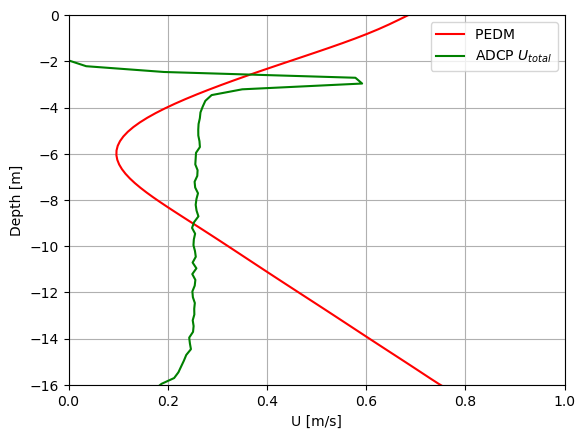

In [383]:
plt.plot(U1_fun(z), z, label="PEDM ", color = 'red')
#plt.scatter( y_fit[1:],-1/(2*wavenumbers), label='EDM', color = 'blue')

U = np.sqrt(north_vel_mean**2+east_vel_mean**2)
plt.plot(U, z1, label='ADCP $U_{total}$', color = 'green')

plt.grid(True)
plt.xlabel("U [m/s]")
plt.ylabel("Depth [m]")
plt.legend()

plt.ylim(-16,0)

plt.xlim(0,1)

In [380]:
hf = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\ADCP_19_01_22_04.mat', 'r')
east_vel = np.array(hf['East_vel'])
north_vel = np.array(hf['North_vel'])
vertical_vel = np.array(hf['Vertical_vel'])
z1 = np.array(hf['z_vec'])
t = hf['time_vec']
hf.close()

time_start = 0*60 # sec
time_stop = 15*60 # sec
time_step = 1 #sec
start_i = int(time_start/time_step)
stop_i = int(time_stop/time_step)

east_vel_mean = np.mean(east_vel[start_i:stop_i], axis=0)
north_vel_mean = np.mean(north_vel[start_i:stop_i], axis=0)
vertical_vel_mean = np.mean(vertical_vel[start_i:stop_i], axis=0)